# Toy DQN playground

In [1]:
import collections

import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [15]:
np.float_power(5, -1.5)

0.08944271909999159

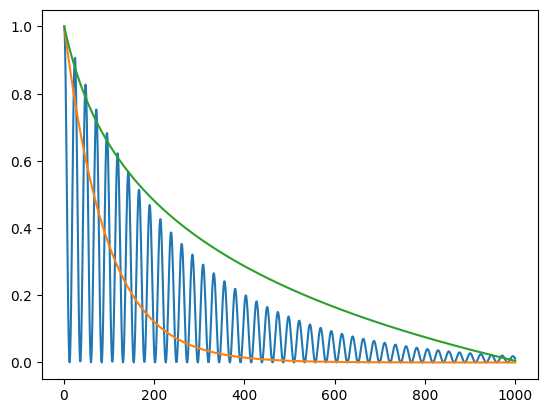

In [65]:
def f_cos(x, s=1, f=0.005, p=100, a=50):
    return 0.5 * s * (np.cos(a * x - a) + 1) * np.exp(-4 / p * (x - 1))


def f_exp(x, s=1, f=0.005, p=100, h=2):
    return s * np.exp(np.log(f / s) * h * (x - 1) / (p - 1))


def f_line(x, s=1, f=0.005, p=100, c=20):
    return -np.emath.logn(
        c,
        (np.float_power(c, -s) * (x - p) + np.float_power(c, -f) * (1 - x)) / (1 - p),
    )


p = 1000
x = list(range(1, p + 1))
plt.plot(x, [f_cos(i, p=p) for i in x])
plt.plot(
    x,
    [
        f_exp(
            i,
            p=p,
        )
        for i in x
    ],
)
plt.plot(x, [f_line(i, p=p) for i in x])
plt.show()

In [1255]:
torch.cuda.is_available()

True

In [1256]:
DEVICE = torch.device("cuda") or torch.device("cpu")
DEVICE

device(type='cuda')

## Utilities

In [1257]:
GAMMA = 0.99
REWARD_STEPS = 0

## Environment

In [1262]:
class BlackJack:
    def _get_reward(self) -> float:
        if self.score < self.win_score:
            return self.step_penalty
        if self.score == self.win_score:
            return self.win_reward
        return self.loose_reward

    def __init__(self) -> None:
        self.actions_dict = {0: 1, 1: 5, 2: 10}

        self.win_score = 100

        self.win_reward = 100
        self.step_penalty = -1
        self.loose_reward = -100

        self.reset()

    def reset(self) -> list[int]:
        # self.score = random.randint(0, self.win_score - 1)
        self.score = 84
        self.steps = 0
        return [self.score / self.win_score]

    def get_state(self) -> list[int]:
        return [self.score]

    def is_terminal(self) -> bool:
        return self.score >= self.win_score

    def interact(self, action: int) -> tuple[list[int], float, bool]:
        if self.is_terminal():
            return [self.score / self.win_score], 0, self.is_terminal()
        self.score += self.actions_dict[action]
        self.steps += 1

        return [self.score / self.win_score], self._get_reward(), self.is_terminal()

    def sample_action(self) -> int:
        return np.random.choice(list(self.actions_dict.keys()))

    def get_observation_shape(self) -> int:
        return 1

    def get_actions_shape(self) -> int:
        return len(self.actions_dict)

    def get_done_info(self) -> tuple[int, float]:
        ep_reward = self.loose_reward if self.score > self.win_score else self.win_reward
        ep_reward += self.steps * self.step_penalty
        return self.steps, ep_reward

In [1263]:
test_env = BlackJack()
print(test_env.interact(2))
print(test_env.interact(1))
print(test_env.interact(0))
print(test_env.is_terminal())

([0.94], -1, False)
([0.99], -1, False)
([1.0], 100, True)
True


## Network

In [1264]:
class DQN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int = 16) -> None:
        super(DQN, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.net(x)

## Replay Buffer

In [1265]:
BATCH_SIZE = 256
REPLAY_SIZE = 1_000
REPLAY_START_SIZE = 1_000

In [1266]:
class ReplayBuffer:
    """
    Buffer class to store the experience from a unique policy
    """

    def __init__(self, capacity: int = REPLAY_SIZE):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def store(self, state, action, reward, done, new_state):
        self.buffer.append((state, action, reward, done, new_state))

    def sample(self, batch_size: int = BATCH_SIZE):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, new_states = zip(
            *[self.buffer[idx] for idx in indices]
        )

        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(dones, dtype=np.uint8),
            np.array(new_states),
        )

## Agent

In [66]:
class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.buffer = exp_buffer
        self._reset()

        self.ep_rewards = []
        self.ep_steps = []

    def _reset(self):
        self.state = self.env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net, epsilon=0.0):
        done_reward = None

        if np.random.random() < epsilon:
            action = self.env.sample_action()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.FloatTensor(state_a).to(DEVICE)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done = self.env.interact(action)
        self.total_reward += reward

        self.buffer.store(self.state, action, reward, is_done, new_state)
        self.state = new_state
        if is_done:
            ep_steps, ep_rev = self.env.get_done_info()
            self.ep_steps.append(ep_steps)
            self.ep_rewards.append(ep_rev)
            done_reward = self.total_reward
            self._reset()

        return done_reward

# Loss

In [1268]:
def calc_loss(batch, net, tgt_net):
    states, actions, rewards, dones, next_states = batch

    states_v = torch.FloatTensor(np.array(states, copy=False)).to(DEVICE)
    next_states_v = torch.FloatTensor(np.array(next_states, copy=False)).to(DEVICE)
    actions_v = torch.LongTensor(actions).to(DEVICE)
    rewards_v = torch.FloatTensor(rewards).to(DEVICE)
    done_mask = torch.BoolTensor(dones).to(DEVICE)

    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    with torch.no_grad():
        next_state_values = tgt_net(next_states_v).max(1)[0]
        next_state_values[done_mask] = 0.0
        next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * GAMMA + rewards_v
    return nn.MSELoss()(state_action_values, expected_state_action_values)

## Training

In [1269]:
np.random.seed(42)
torch.manual_seed(42)

In [1270]:
LEARNING_RATE = 0.005  # 0.005

env = BlackJack()
net = DQN(input_dim=env.get_observation_shape(), output_dim=env.get_actions_shape()).to(
    DEVICE
)
tgt_net = DQN(
    input_dim=env.get_observation_shape(), output_dim=env.get_actions_shape()
).to(DEVICE)
optimizer = optim.Adam(
    net.parameters(),
    lr=LEARNING_RATE,
    # eps=1e-3
)

In [1271]:
EPOCHS = 5000  # 5000

CLIP_GRAD = 0.1

SYNC_STEPS = 100  # 100

EPSILON_DECAY_LAST_STEP = int((EPOCHS + REPLAY_START_SIZE) * 0.55)  # 0.55
# EPSILON_DECAY_LAST_STEP = int(EPOCHS*0.7)
EPSILON_START = 1.0
EPSILON_FINAL = 0.01  # 0.01

In [1272]:
buffer = ReplayBuffer()
agent = Agent(env, buffer)

step_count = 0
epsilon = EPSILON_START

mean_last_n_rewards = []
mean_last_n_ep_len = []
epoch_loss = []


while len(agent.buffer) < REPLAY_START_SIZE:
    step_count += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - step_count / EPSILON_DECAY_LAST_STEP)
    reward = agent.play_step(net, epsilon)

loop = tqdm(range(EPOCHS), desc="Epoch")

for _ in loop:
    step_count += 1

    epsilon = max(EPSILON_FINAL, EPSILON_START - step_count / EPSILON_DECAY_LAST_STEP)

    reward = agent.play_step(net, epsilon)

    # print(np.mean(agent.ep_rewards))

    if step_count % SYNC_STEPS == 0:
        tgt_net.load_state_dict(net.state_dict())

    optimizer.zero_grad()
    batch = buffer.sample()
    loss_t = calc_loss(batch, net, tgt_net)
    loss_t.backward()
    nn.utils.clip_grad_norm_(net.parameters(), CLIP_GRAD)
    optimizer.step()

    # logging
    mean_last_n_rewards.append(np.mean(agent.ep_rewards[-10:]))
    mean_last_n_ep_len.append(np.mean(agent.ep_steps[-10:]))
    epoch_loss.append(loss_t.item())

    loop.set_postfix(
        {
            "Mean reward": mean_last_n_rewards[-1],
            "Mean ep len": mean_last_n_ep_len[-1],
            "Mean Loss": epoch_loss[-1],
            "Eps": epsilon,
        }
    )
    # if epoch_loss[-1] < 0:
    #     print(loss_v.item())
    #     break

Epoch:   2%|▏         | 81/5000 [00:00<00:32, 152.20it/s, Mean reward=-63.4, Mean ep len=3.4, Mean Loss=2.2e+3, Eps=0.803] 

Epoch: 100%|██████████| 5000/5000 [00:40<00:00, 122.33it/s, Mean reward=92, Mean ep len=8, Mean Loss=37.2, Eps=0.01]          


In [1273]:
np.max(mean_last_n_rewards)

93.2

In [1274]:
def moving_average(x, w=100):
    # return np.convolve(x, np.ones(w), 'same') / w
    return scipy.signal.savgol_filter(x, w, min(3, w - 1))


# moving_average([1, 2, 3, 4], 2)

[]

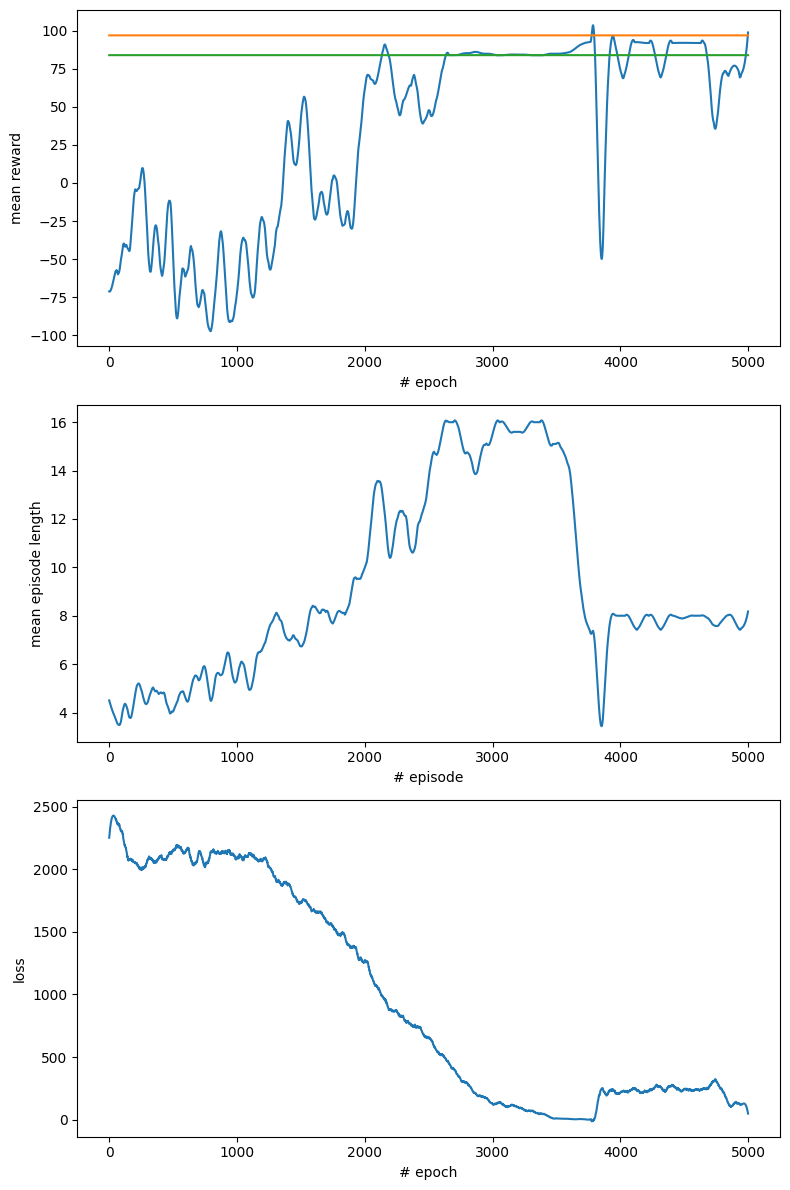

In [1275]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Mean Reward per epoch

axs[0].plot(range(EPOCHS), moving_average(mean_last_n_rewards))
axs[0].plot(range(EPOCHS), [98] * EPOCHS)  # optimal value
axs[0].plot(range(EPOCHS), [85] * EPOCHS)  # suboptimal value
axs[0].set_xlabel("# epoch")
axs[0].set_ylabel("mean reward")

# Mean Episode length per epoch
axs[1].plot(range(EPOCHS), moving_average(mean_last_n_ep_len))
axs[1].set_xlabel("# episode")
axs[1].set_ylabel("mean episode length")


# Epoch loss
axs[2].plot(range(EPOCHS), moving_average(epoch_loss))
axs[2].set_xlabel("# epoch")
axs[2].set_ylabel("loss")

plt.tight_layout()
plt.plot()